In [ ]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 5.3 MB/s 
     |████████████████████████████████| 596 kB 47.9 MB/s 
     |████████████████████████████████| 6.8 MB 30.3 MB/s 
     |████████████████████████████████| 895 kB 49.7 MB/s 
     |████████████████████████████████| 67 kB 5.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import pandas as pd
import numpy as np

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import torch
from torch.utils.data import (TensorDataset, DataLoader,
                              RandomSampler, SequentialSampler)
from transformers import BertTokenizer, BertConfig
from transformers import BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
from distutils.version import LooseVersion as LV
from sklearn.model_selection import train_test_split
import io

#path = r'D:\tirocinioLC\tirocinioLC'
from google.colab import drive
drive.mount('/content/drive')
directory = '/content/drive/My Drive/Text Analytics/Data/'

Mounted at /content/drive


In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    devicename = '['+torch.cuda.get_device_name(0)+']'
else:
    device = torch.device('cpu')
    devicename = ""
    
print('Using PyTorch version:', torch.__version__,
      'Device:', device, devicename)
assert(LV(torch.__version__) >= LV("1.0.0"))

Using PyTorch version: 1.10.0+cu111 Device: cuda [Tesla K80]


Import dataset

In [ ]:
df = pd.read_json(directory+'cleandf3.json')

df.Data = pd.to_datetime(df.Data)
df = df[df.Data.dt.year < 2019]
df = df.sample(frac=0.85, random_state=42)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32039 entries, 2840 to 29371
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ID                  32039 non-null  int64         
 1   Titolo_Rif          32037 non-null  object        
 2   Rating              32039 non-null  object        
 3   Nome_Autore         32039 non-null  object        
 4   Data                32039 non-null  datetime64[ns]
 5   Numero_Capitoli     32039 non-null  int64         
 6   Racconto_Text_Only  32039 non-null  object        
 7   N_Tot_Rec           32039 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 2.2+ MB
None


,ID,Titolo_Rif,Rating,Nome_Autore,Data,Numero_Capitoli,Racconto_Text_Only,N_Tot_Rec
2840,59819,Tutto Per Una Meravigliosa Partita di Quidditch,verde,Gillywater,2005-11-19,1,Buon Compleanno Love! ...,12
33471,1135350,Dopotutto Babbanologia non è inutile...,verde,Gils_Malfoy,2012-06-29,1,AVVERTENZE! Prima di iniziare a leggere è bene...,7
34947,1260606,Non piangere.,verde,A n o n y m o u s Rei,2012-11-09,1,"Ti tappi un altro po’ le orecchie, Theo. Fa...",2
35908,1407567,Una finestra sul passato,verde,Ma_AiLing,2012-11-24,1,Il professor Lupin si stava dirigendo nel suo ...,2
22312,690486,Qualcuno uccida Potter,verde,lotti_,2011-06-04,1,"Un raggio di sole scarlatto, tenue e delicata ...",4


In [ ]:
df = df[df['Rating']!='giallo']
df = df[df['Rating']!='arancione']
########SAMPLE (MEMORY ISSUES)
df_rosso = df[df['Rating']=='rosso']
df_verde = df[df['Rating']=='verde']
print(len(df_verde))
df_verde = df_verde.sample(frac=0.85, random_state=42)
print(len(df_verde))

df = pd.concat([df_rosso, df_verde])
df.head()

22223
18890


,ID,Titolo_Rif,Rating,Nome_Autore,Data,Numero_Capitoli,Racconto_Text_Only,N_Tot_Rec
36795,1538089,Professor Potter,rosso,LadyDaredevil,2013-01-15,1,A LadyDepp :) PROFESSOR POTTER La gr...,10
8972,178294,tra ron e grattastinchi,rosso,JoeMarch,2007-10-11,1,"TRA RON E GRATTASTINCHI ""no"" ""eddai hermione...",3
51219,3534405,Love always remains,rosso,Alex91,2016-09-17,1,@page p a: link Una ...,3
8740,172344,L'ultima alba,rosso,alicesimone,2007-10-16,1,La Seconda Guerra aveva ormai raggiunto il suo...,8
50828,3494175,A thousand kisses - Lo Specchio delle Anime,rosso,Marne,2016-07-20,1,Comunicazione di servizio:...,5


In [ ]:
target = df[['Rating']]
del df['Rating']

In [ ]:
from sklearn.model_selection import train_test_split, RepeatedKFold

#split on train-test 
x_train, x_test, y_train, y_test = train_test_split(df, target, test_size=0.30, random_state=42, stratify=target, shuffle=True) 
print(f"Train set size: {len(x_train)}\nTest set size: {len(x_test)}")

Train set size: 14441
Test set size: 6189


In [ ]:
x_test.to_csv(directory+'x_test_final1v1.csv')
y_test.to_csv(directory+'y_test_final1v1.csv')

Text Preparation

In [ ]:
sentences_train = ["[CLS] " + s for s in x_train.Racconto_Text_Only]
labels_train  = [1 if (value=='rosso') else 0 for value in y_train.Rating]

In [ ]:
from transformers import AutoModel, AutoTokenizer

model_name = "dbmdz/bert-base-italian-xxl-cased"

tokenizer = BertTokenizer.from_pretrained(model_name)

model = AutoModel.from_pretrained(model_name)

Downloading:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/230k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/425M [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
from tqdm import tqdm
#tokenized_train  = [tokenizer.tokenize(s) for s in tqdm(sentences_train)]

In [ ]:
import pickle
#with open(directory+r'RATING1v1tokenized_train_FINAL.pkl','wb') as outfile:
#  pickle.dump(tokenized_train, outfile)

In [ ]:
b_file = open(directory+r"RATING1v1tokenized_train_FINAL.pkl", "rb")
tokenized_train = pickle.load(b_file)

In [ ]:
len(tokenized_train)

14441

In [ ]:
MAX_LEN_train = 125
K = MAX_LEN_train

tokenized_train = [t[((len(t) // 2) - (K // 2)) : ((len(t) // 2) + (K // 2) + 1) ]+['SEP'] for t in tokenized_train]
tokenized_train = [["[CLS]"] + s for s in tokenized_train]

print ("The truncated tokenized first train sentence:")
print (tokenized_train[0])

The truncated tokenized first train sentence:
['[CLS]', 'mai', 'sopporta', '##to', 'le', 'persone', 'così', 'irra', '##zionali', 'come', 'lei', '.', 'Pa', '##zze', '.', '«', 'Io', 'alle', 'volte', 'mi', 'sie', '##do', 'così', 'per', 'evitare', 'che', 'dei', 'Gor', '##gos', '##pri', '##zzi', 'Ur', '##tica', '##nti', 'mi', 'entri', '##no', 'nelle', 'nar', '##ici', 'impe', '##dendo', '##mi', 'di', 'subire', 'l', '’', 'influenza', 'benefic', '##a', 'degli', 'Er', '##ma', '##don', '##ti', 'che', 'riescono', 'ad', 'aprire', 'il', 'mio', 'terzo', 'occhio', ',', 'e', 'quindi', 'pensavo', 'che', 'anch', '-', '»', 'cominciò', 'a', 'dirmi', 'in', 'una', 'parla', '##nti', '##na', 'talmente', 'lenta', 'e', 'sorpresa', 'da', 'far', 'concorrenza', 'a', 'R', '##ü', '##f', '.', 'La', 'interru', '##ppi', 'brus', '##camente', '.', '«', 'No', '.', 'No', '.', 'No', '.', '»', '«', 'Perché', 'mi', 'dici', 'di', 'no', '?', 'Io', 'non', 'ti', 'ho', 'chiesto', 'niente', '!', '»', 'domand', '##ò', 'con', 'fare',

In [ ]:
ids_train = [tokenizer.convert_tokens_to_ids(t) for t in tokenized_train]
ids_train = np.array([np.pad(i, (0, 128-len(i)),
                            mode='constant') for i in ids_train])

print ("The indices of the first training sentence:")
print (ids_train[0])

The indices of the first training sentence:
[  102   779 17679   112   199  1022   763 16019  1056   342   894   697
   489  1942   697  1188  1111   518  1450   318  9613   165   763   156
  3508   158   292 21164  9616   787   780  9034   502  9696   318 15899
   169   841 11376   391  1606  1395   226   120 17420   181  5817  5665
  4645 30878   483  4902   174  2143   116   158 11470   382  5585   162
   619  2949 10987  1307   126  1092  5910   158  4037   179  3823 10899
   111  6393   139   224  2269  9696   230 13526  9235   126  6809   203
   587  4013   111   257 30982 30896   697   309 15211  1893 21425 10944
   697  1188   468   697   468   697   468   697  3823  1188  1529   318
  3462   120   366  3098  1111   212   364   480  2973  1377  2692  3823
 26365 30940   153   585 17198   201   101     0]


In [ ]:
amasks_train = []

for seq in ids_train:
  seq_mask = [float(i>0) for i in seq]
  amasks_train.append(seq_mask)

In [ ]:
(train_inputs, validation_inputs,
 train_labels, validation_labels) = train_test_split(ids_train, labels_train,
                                                     random_state=42,
                                                     test_size=0.1)
(train_masks, validation_masks,
 _, _) = train_test_split(amasks_train, ids_train,
                          random_state=42, test_size=0.1)

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks  = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks  = torch.tensor(validation_masks)

In [ ]:
BATCH_SIZE = 32

print('Datasets:')
print('Train: ', end="")
train_data = TensorDataset(train_inputs, train_masks,
                           train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler,
                              batch_size=BATCH_SIZE)
print(len(train_data), 'documents')

print('Validation: ', end="")
validation_data = TensorDataset(validation_inputs, validation_masks,
                                validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,
                                   sampler=validation_sampler,
                                   batch_size=BATCH_SIZE)
print(len(validation_data), 'documents')


Datasets:
Train: 12996 documents
Validation: 1445 documents


Bert model initialization

In [ ]:
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

In [ ]:
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32102, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
print('Pretrained BERT model "{}" loaded'.format(model_name))

Pretrained BERT model "dbmdz/bert-base-italian-xxl-cased" loaded


# MODIFICHE

In [ ]:
EPOCHS = 3 #first run with 4
WEIGHT_DECAY = 0.01
LR = 2e-5
WARMUP_STEPS =int(0.2*len(train_dataloader))

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters()
                if not any(nd in n for nd in no_decay)],
     'weight_decay': WEIGHT_DECAY},
    {'params': [p for n, p in model.named_parameters()
                if any(nd in n for nd in no_decay)],
     'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=LR, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS,
                                 num_training_steps =len(train_dataloader)*EPOCHS)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
import torch.nn as nn
from sklearn.metrics import f1_score

In [ ]:
#class_weights = [2, 1]
#class_weights = torch.as_tensor(class_weights)
#class_weights.to(device)
#loss_fn = nn.CrossEntropyLoss()#weight=class_weights)
class_weights = [1,2]
class_weights = torch.FloatTensor(class_weights).cuda()
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
def f1_score_func(preds, labels):
    preds_copy = torch.tensor(preds)
    preds_flat = np.argmax(preds_copy.cpu(), axis=1).flatten()
    labels_flat = labels.cpu().flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [ ]:
from tabulate import tabulate
def train(epoch, loss_vector=None, log_interval=200):
  # Set model to training mode
  model.train()
  # Reset tracking variables at the beginning of each epoch

  total_loss, batch_loss, batch_counts, f1_value_train_batch, f1_value_train_tot  = 0, 0, 0, 0, 0
  
  # Loop over each batch from the training set
  for step, batch in enumerate(train_dataloader):

    # Copy data to GPU if needed
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Zero gradient buffers ##il v2del.zero_grad()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None,
                    attention_mask=b_input_mask, labels=b_labels) 
    
    ###########################################################################

    ###################################################################

    loss = loss_fn(outputs.logits, b_labels) 
    #batch_loss += loss.item()
    total_loss += loss.item()

    #f1_value_train_batch += f1_score_func(outputs[0], b_labels)
    f1_value_train_tot += f1_score_func(outputs.logits, b_labels) 

    if loss_vector is not None: ############# Qui ci andrà messa la val loss (da provare a prendere sopra)
        loss_vector.append(loss.item())

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()
    scheduler.step()

    if step % log_interval == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, step * len(b_input_ids),
                len(train_dataloader.dataset),
                100. * step / len(train_dataloader), loss))

  avg_train_loss = total_loss / len(train_dataloader)
  avg_f1_value = f1_value_train_tot / len(train_dataloader)
  print('\n avg_train_loss', avg_train_loss)
  print('avg_f1_value', avg_f1_value)

def evaluate(loader, loss_vector=None, test=False):
    model.eval()

    n_correct, n_all = 0, 0
    TP = 0
    TN = 0
    FP = 0
    FN = 0

    b_labels_v2 = torch.tensor([],dtype=torch.long)
    b_input_ids_v2 = torch.tensor([], dtype=torch.long)
    b_attn_mask_v2 = torch.tensor([], dtype=torch.long)

    batchcount = 0
    for batch in loader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        b_labels_v2 = torch.cat((b_labels_v2.to(device), b_labels), 0)
        b_input_ids_v2 = torch.cat((b_input_ids_v2.to(device), b_input_ids), 0)
        b_attn_mask_v2 = torch.cat((b_attn_mask_v2.to(device), b_input_mask), 0)

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None,
                          attention_mask=b_input_mask)
            logits = outputs.logits

        logits = logits.detach().cpu()#.numpy()

        #Predictions
        predictions = np.argmax(logits.numpy(), axis=1)
        #Labels
        labels = b_labels.to('cpu').numpy()

        n_correct += np.sum(predictions == labels)
        n_all += len(labels)

        for truth, pred in zip(labels, predictions):
          if truth == 0 and pred == 0:
            TN +=1
          elif truth == 1 and pred == 1:
            TP +=1
          elif truth == 1 and pred == 0:
            FN +=1
          elif truth ==0 and pred == 1:
            FP +=1

        if test:
          batchcount += 1
          print("Ho preso", batchcount, 'batches su ?')

    with torch.no_grad():
        logits_v2 = model(b_input_ids_v2, b_attn_mask_v2)

    if test:
      print('Ho fatto le logits')

    del b_input_ids_v2
    del b_attn_mask_v2
    torch.cuda.empty_cache()

    if test:
      print('Ho svuotato la cache')

    b_labels_v2 = b_labels_v2.to(device)

    if test:
      print('Ho spostato le labels sul device')

    loss = loss_fn(logits_v2.logits, b_labels_v2)

    if test:
      print('Ho calcolato la val loss')
    val_loss = loss.item()

    print('Accuracy: [{}/{}] {:.4f}'.format(n_correct, n_all,
                                          n_correct/n_all))
    print('VAL LOSS', val_loss)

    if (TP+FP!=0):
      precision_1 = (TP) / (TP+FP)
    else:
      precision_1 = 0

    if (TP+FN!=0):
      recall_1 = (TP) / (TP+FN)
    else:
      recall_1 = 0

    precision_0 = TN / (TN+FN)
    recall_0 = TN / (TN+FP)

    f1_0 = 2* ((precision_0*recall_0) / (precision_0+recall_0))
    if (precision_1+recall_1) != 0:
      f1_1 = 2* ((precision_1*recall_1) / (precision_1+recall_1))
    else:
      f1_1 = 0

    data = [['verde', precision_0, recall_0, f1_0],
            ['rosso', precision_1, recall_1, f1_1]]

    data2 = [['predROSSO', TP, FP], 
             ['predVERDE', FN, TN]]

    print(tabulate(data, headers=["Class", "Precision", "Recall", "F1"]))
    print()
    print(tabulate(data2, headers=['', 'truthROSSO', 'truthVERDE']))

    if loss_vector is not None: ############# Qui ci andrà messa la val loss (da provare a prendere sopra)
      loss_vector.append(val_loss)


In [ ]:
import warnings
warnings.filterwarnings("ignore")
train_lossv = []
val_lossv = []
print("Start training...\n")
for epoch in range(1, EPOCHS + 1):
    print()
    train(epoch, train_lossv)
    print('\nValidation set:')
    evaluate(validation_dataloader, val_lossv)

Start training...


Train Epoch: 1 [0/12996 (0%)]	Loss: 0.634003
Train Epoch: 1 [6400/12996 (49%)]	Loss: 0.303779
Train Epoch: 1 [12800/12996 (98%)]	Loss: 0.412701

 avg_train_loss 0.33775566576886235
avg_f1_value 0.9128738987554241

Validation set:
Accuracy: [1322/1445] 0.9149
VAL LOSS 0.3389662206172943
Class      Precision    Recall        F1
-------  -----------  --------  --------
verde       0.948718  0.958111  0.953391
rosso       0.537815  0.484848  0.50996

             truthROSSO    truthVERDE
---------  ------------  ------------
predROSSO            64            55
predVERDE            68          1258

Train Epoch: 2 [0/12996 (0%)]	Loss: 0.414044
Train Epoch: 2 [6400/12996 (49%)]	Loss: 0.422997
Train Epoch: 2 [12800/12996 (98%)]	Loss: 0.429631

 avg_train_loss 0.2530107903832007
avg_f1_value 0.9381017857940139

Validation set:
Accuracy: [1341/1445] 0.9280
VAL LOSS 0.3057830333709717
Class      Precision    Recall        F1
-------  -----------  --------  --------
verde   

In [ ]:
val_lossv

[0.3389662206172943, 0.3057830333709717, 0.32171759009361267]

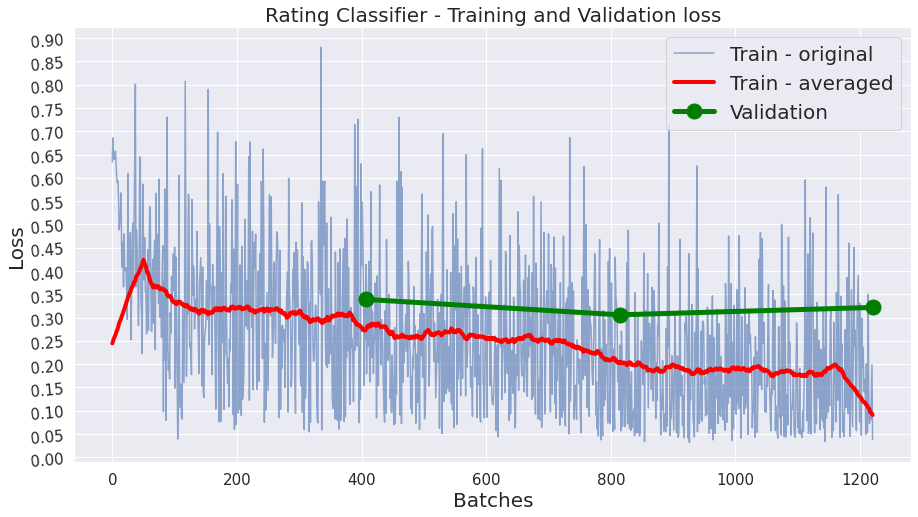

In [ ]:
%matplotlib inline
plt.figure(figsize=(15,8))
plt.title("Rating Classifier - Training and Validation loss", fontsize=20)
plt.xlabel("Batches", fontsize=20)
plt.ylabel("Loss", fontsize=20)


plt.plot(train_lossv, label='Train - original', alpha=0.60)
plt.plot(np.convolve(train_lossv, np.ones(101), 'same') / 101,
         label='Train - averaged', linewidth=4, color='red')

plt.yticks(np.arange(0,1,0.05), fontsize=15, rotation=5)
plt.xticks(fontsize=15)
val_ticks = np.arange(len(train_lossv)/len(val_lossv), len(train_lossv)+len(train_lossv)/len(val_lossv), len(train_lossv)/len(val_lossv))
plt.plot(val_ticks, val_lossv, label='Validation', marker='o', linewidth=5, markersize=15, color='green')

plt.legend(loc='best', fontsize=20)
plt.show()

In [ ]:
with open(directory+r'XXXMODEL_RATING_1v1_2_1_3epoche.pkl','wb') as outfile:
    pickle.dump(model, outfile)

Evaluation

In [ ]:
#del train_dataloader

In [ ]:
#del validation_dataloader

In [ ]:
#del b_labels_v2

In [ ]:
#torch.cuda.empty_cache()
print('Test set:')
#evaluate(test_dataloader, test=True)

Test set:
